# A TUTORIAL ON GRADIENT BOOSTING CLASSIFICATION WITH XGBoost

by Sebastian T. Glavind, August, 2020

# Introduction

In this tutorial, we will consider how to define, train, and predict with gradient boosted decision trees using `XGBoost`. First, we will consider how to use gradient boosting for multi-class classification. Second, we will see how to choose the hyperparameters using Bayesian optimization with a Gaussian process prior. Third, we will consider the feature importance functionalities of `XGBoost`. The interested reader is referred to e.g. the textbook of Hastie et al. (2009) for an introduction to gradient boosting (machines), Chen and Guestrin (2016) for a reference on `XGBoost`, and Shahriari et al. (2016) for a review on Bayesian optimization.

We will consider a small data set in the tutorial, i.e. the Wine recognition data set, so that training can be performed on a standard computer.
***
T. Hastie, R. Tibshirani, J. H. Friedman, The Elements of Statistical Learning, Springer New York, 2009.

T. Chen, C. Guestrin, XGBoost: A scalable tree boosting system, in: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, ACM, 2016, pp. 785-794, http://dx.doi.org/10.1145/2939672.2939785

B. Shahriari, K. Swersky, Z. Wang, R. P. Adams, N. de Freitas, Taking the human out of the loop: A review of bayesian optimization, in: Proceedings of the IEEE, Vol. 104, 2016, pp. 148-175. 
***

# Prelude

In [17]:
import sklearn.utils
import sklearn.metrics
import sklearn.model_selection
import sklearn.decomposition
from sklearn.datasets import load_wine
import pandas as pd
import xgboost as xgb
import GPyOpt
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Multi-class classification with XGBoost


## Data set

In this tutorial, we will consider the Wine recognition data set, see below, which ships with `scikit-learn`;

In [18]:
WineData = load_wine()
print(WineData['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

### Collect raw data

In [19]:
Xraw, yraw = WineData['data'], WineData['target']
nTarget = np.array([sum(yraw==0), sum(yraw==1), sum(yraw==2)])
print('Samples in each class', nTarget)

Samples in each class [59 71 48]


### Simple random over-sampling (Bootstrapping) to manage class-imbalance

In [20]:
Xboost = list()
yboost = list()
for i in range(len(nTarget)):
    index_i = np.where( yraw==i )[0]
    X_i_boost = Xraw[index_i,:]
    y_i_boost = yraw[index_i]
    
    if nTarget[i] < max(nTarget):
        index_i_boost = sklearn.utils.resample(index_i, replace=True, n_samples=max(nTarget)-nTarget[i],
                                              random_state=123)
        X_i_boost = np.vstack([ X_i_boost, Xraw[index_i_boost,:] ])
        y_i_boost = np.concatenate([ y_i_boost, yraw[index_i_boost] ]) 
    
    Xboost.append(X_i_boost)
    yboost.append(y_i_boost)

Xboost = np.vstack(Xboost)
yboost = np.concatenate(yboost)

### Define train and test data

In [21]:
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xboost, yboost, stratify=yboost, 
                                                                        train_size=.8, shuffle=True, 
                                                                        random_state=1)

### Standardize data 

In [22]:
# Standardize features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Xtrain)
sXtrain = scaler.transform(Xtrain)
sXtest = scaler.transform(Xtest)

### Principal component analysis

See e.g. Geron (2019) - decision tree prefer othogonal features.

***
A. Geron, Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O’Reilly Media, 2019.
***

In [23]:
# PCA of standardized features
pca_trans = sklearn.decomposition.PCA()
tXtrain = pca_trans.fit(sXtrain)
tXtrain = pca_trans.transform(sXtrain)
tXtest = pca_trans.transform(sXtest)

## XGBoost - no feature transformation

In [24]:
xgb_clas = xgb.XGBClassifier(seed=0)
xgb_clas.fit(Xtrain,ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### Training error

In [25]:
pred_train = xgb_clas.predict(Xtrain)
pred_train_prob = xgb_clas.predict_proba(Xtrain)
print(sklearn.metrics.classification_report(ytrain,pred_train))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytrain, pred_train))
print('Predictions (prob)')
print(np.round(pred_train_prob[1:10,:],2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        57

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

Confusion:
[[57  0  0]
 [ 0 56  0]
 [ 0  0 57]]
Predictions (prob)
[[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.99 0.01]
 [0.   1.   0.  ]
 [1.   0.   0.  ]]


### Test error

In [26]:
pred_test = xgb_clas.predict(Xtest)
pred_test_prob = xgb_clas.predict_proba(Xtest)
print(sklearn.metrics.classification_report(ytest, pred_test))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytest, pred_test))
print('Predictions (prob)')
print(np.round(pred_test_prob[1:10,:],2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.96        14

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43

Confusion:
[[14  0  0]
 [ 0 15  0]
 [ 0  1 13]]
Predictions (prob)
[[0.01 0.   0.99]
 [0.   0.01 0.99]
 [0.   0.96 0.04]
 [0.   0.99 0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.99 0.   0.01]
 [1.   0.   0.  ]]


## XGBoost - standardize features

In [27]:
xgb_clas_s = xgb.XGBClassifier(seed=0)
xgb_clas_s.fit(sXtrain,ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### Training error

In [28]:
pred_train_s = xgb_clas_s.predict(sXtrain)
pred_train_prob_s = xgb_clas_s.predict_proba(sXtrain)
print(sklearn.metrics.classification_report(ytrain,pred_train_s))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytrain,pred_train_s))
print('Predictions (prob)')
print(np.round(pred_train_prob_s[1:10,:],2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        57

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

Confusion:
[[57  0  0]
 [ 0 56  0]
 [ 0  0 57]]
Predictions (prob)
[[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.99 0.01]
 [0.   1.   0.  ]
 [1.   0.   0.  ]]


### Test error

In [29]:
pred_test_s = xgb_clas_s.predict(sXtest)
pred_test_prob_s = xgb_clas_s.predict_proba(sXtest)
print(sklearn.metrics.classification_report(ytest,pred_test_s))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytest,pred_test_s))
print('Predictions (prob)')
print(np.round(pred_test_prob_s[1:10,:],2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.96        14

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43

Confusion:
[[14  0  0]
 [ 0 15  0]
 [ 0  1 13]]
Predictions (prob)
[[0.01 0.   0.99]
 [0.   0.01 0.99]
 [0.   0.96 0.04]
 [0.   0.99 0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.99 0.   0.01]
 [1.   0.   0.  ]]


This has no effect compared to the no scaling case, which is expected given that decision trees operate in a discrete domain. 

## XGBoost - feature pre-processing with PCA

In [30]:
xgb_clas_t = xgb.XGBClassifier(seed=0)
xgb_clas_t.fit(tXtrain,ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### Training error

In [31]:
pred_train_t = xgb_clas_t.predict(tXtrain)
pred_train_prob_t = xgb_clas_t.predict_proba(tXtrain)
print(sklearn.metrics.classification_report(ytrain,pred_train_t))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytrain,pred_train_t))
print('Predictions (prob)')
print(np.round(pred_train_prob_t[1:10,:],2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        57

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

Confusion:
[[57  0  0]
 [ 0 56  0]
 [ 0  0 57]]
Predictions (prob)
[[0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   1.   0.  ]
 [0.99 0.   0.  ]
 [1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.01 0.96 0.03]
 [0.   1.   0.  ]
 [1.   0.   0.  ]]


### Test error

In [32]:
pred_test_t = xgb_clas_t.predict(tXtest)
pred_test_prob_t = xgb_clas_t.predict_proba(tXtest)
print(sklearn.metrics.classification_report(ytest,pred_test_t))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytest,pred_test_t))
print('Predictions (prob)')
print(np.round(pred_test_prob_t[1:10,:],2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        14

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

Confusion:
[[14  0  0]
 [ 0 15  0]
 [ 0  0 14]]
Predictions (prob)
[[0.   0.   1.  ]
 [0.   0.01 0.99]
 [0.   0.99 0.01]
 [0.   1.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.97 0.02 0.  ]]


This has an effect compared to the no scaling case, i.e. boost accuracy for 98\% to 100\%, as decision tree prefer orthogonal features, see e.g. Geron (2019).


# Bayesian optimization with GPyOpt

As we have already obtained perfect performance on the test set using PCA pre-processing with the default parameters, there is no idea in trying to optimize this model further, so in this section we will try to improve performance on the original (un-transformed) data.

The hyper-parameters optimization in this section will be performed using Bayesian optimization with a Gaussian process prior, see e.g. Shahriari et al. (2016) for a reference. In this regard, we will use the functionalities of `GPyOpt` in the implementation of Bayesian optimization, see https://github.com/SheffieldML/GPyOpt.

***
B. Shahriari, K. Swersky, Z. Wang, R. P. Adams, N. de Freitas, Taking the human out of the loop: A review of Bayesian optimization, in: Proceedings of the IEEE, Vol. 104, 2016, pp. 148-175.
***

In [33]:
from xgboost import XGBClassifier
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [34]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0.001, 0.3)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.001, 0.3)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (2, 4, 6, 8, 10, 12)},
        {'name': 'n_estimators', 'type':'discrete','domain': (100, 200, 300, 400, 500)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
    
    # define the pipeline
    steps = list()
#     steps.append(('scaler', sklearn.preprocessing.StandardScaler() ))
#     steps.append(('pca', sklearn.decomposition.PCA() ))
    steps.append(('model', XGBClassifier(learning_rate=parameters[0],
                              gamma=parameters[1],
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight=int(parameters[4]),
                              objective='mlogloss') ))
    pipe = Pipeline(steps=steps)
    
    score = cross_val_score(
        pipe, Xtrain, ytrain, scoring='neg_log_loss', cv=cv).mean()
    score = np.array(score)
    print(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 exact_feval=True, 
                                 normalize_Y=True,
                                 acquisition_optimizer_type='lbfgs', 
                                 model_update_interval=1, 
                                 evaluator_type='sequential',
                                 maximize=True, # maximize, i.e. minimize negative objective
                                 num_cores=1)
optimizer.run_optimization(max_iter=40)

-0.10083793030969579
-0.24960152090472332
-0.19155298872467347
-0.09375466559534235
-0.6035688140813043
-0.09375894131097832
-0.09996892088229822
-0.09426102325977648
-0.6658623250091777
-0.9834710019476274
-0.1985456337385318
-0.1985456337385318
-0.1985456337385318
-0.1988866460893084
-0.7733512801282545
-0.1960249077528715
-0.19709799920811372
-0.7140221977935118
-0.19475769575904398
-0.19666112192413387
-0.19512908555129
-0.9987070409690633
-0.1052140237078728
-0.10332427988486255
-0.10399644812842941
-0.09878283611991825
-0.09778701548793298
-0.09871185080504374
-0.09798807175693047
-0.09768934001296978
-0.09852958704235361
-0.09911754831178662
-0.09852958704235361
-0.09852958704235361


### Convergence plots for the optimization

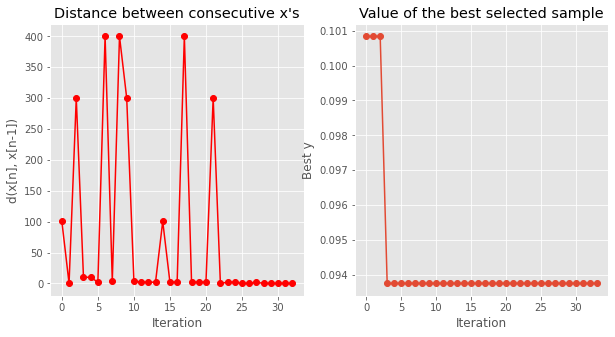

In [39]:
optimizer.plot_convergence()

### Optimal parameter setting and corresponding model

In [35]:
params_opt = (optimizer.x_opt); 
print('Best parameter setting:', params_opt)

model_opt = XGBClassifier(learning_rate=params_opt[0],
                          gamma=params_opt[1],
                          max_depth=int(params_opt[2]),
                          n_estimators=int(params_opt[3]),
                          min_child_weight=int(params_opt[4]),
                          objective='mlogloss',
                          seed=0
                          )
model_opt.fit(tXtrain,ytrain)

Best parameter setting: [1.03124073e-01 3.60896032e-02 2.00000000e+00 1.00000000e+02
 1.00000000e+00]


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.03608960323739712,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.10312407313108196, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### Training error

In [37]:
pred_train_opt = model_opt.predict(tXtrain)
pred_train_prob_opt = model_opt.predict_proba(tXtrain)
print(sklearn.metrics.classification_report(ytrain,pred_train_opt))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytrain,pred_train_opt))
print('Predictions (prob)')
print(np.round(pred_train_prob_opt[1:10,:],3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        57

    accuracy                           1.00       170
   macro avg       1.00      1.00      1.00       170
weighted avg       1.00      1.00      1.00       170

Confusion:
[[57  0  0]
 [ 0 56  0]
 [ 0  0 57]]
Predictions (prob)
[[0.001 0.003 0.996]
 [0.003 0.001 0.996]
 [0.002 0.997 0.001]
 [0.994 0.003 0.003]
 [0.998 0.001 0.001]
 [0.002 0.997 0.001]
 [0.009 0.952 0.039]
 [0.002 0.997 0.001]
 [0.998 0.001 0.001]]


### Test error

In [38]:
pred_test_opt = model_opt.predict(tXtest)
pred_test_prob_opt = model_opt.predict_proba(tXtest)
print(sklearn.metrics.classification_report(ytest,pred_test_opt))
print('Confusion:')
print(sklearn.metrics.confusion_matrix(ytest,pred_test_opt))
print('Predictions (prob)')
print(np.round(pred_test_prob_opt[1:10,:],3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        14

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

Confusion:
[[14  0  0]
 [ 0 15  0]
 [ 0  0 14]]
Predictions (prob)
[[0.001 0.003 0.996]
 [0.001 0.007 0.992]
 [0.001 0.987 0.012]
 [0.004 0.995 0.001]
 [0.998 0.001 0.001]
 [0.995 0.003 0.002]
 [0.998 0.001 0.001]
 [0.99  0.009 0.002]
 [0.955 0.044 0.001]]


It appears that perfect performance can also be obtained for this case by optimizing the hyper-parameters for a model trained on the original (non-transformed) data. For real application, we may need to both transform our data and optimize the hyper-parameters of the `XGBoost` algorithm to get the best possible performance.


# Feature importance

A benefit of using the original features for model building is that the inherent feature importance functionalities of `XGBoost`, and most other tree-based methods, becomes directly interpretable. Here, the feature importance’s for a single decision tree are calculated as the amount that each feature split point improves the performance measure, weighted by the number of observations the node is responsible for. The feature importance’s from all trees are then averaged within the model to produce the final score, see e.g. Brownlee (2020).

***
J. Brownlee, XGBoost with Python, 2020.
***


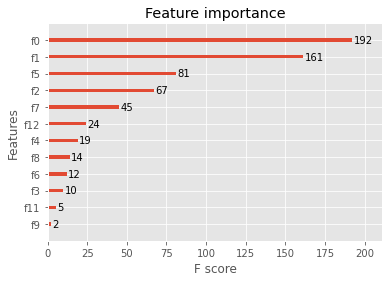

In [44]:
xgb.plot_importance(model_opt);

We see that the features are automatically named according to their index in the input array;

In [46]:
WineData['feature_names']

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

Thus, *alcohol* is the most important feature in this case, and the least important feature is *proanthocyanins*.